In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")

/tmp/ipykernel_1500520/1703994658.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


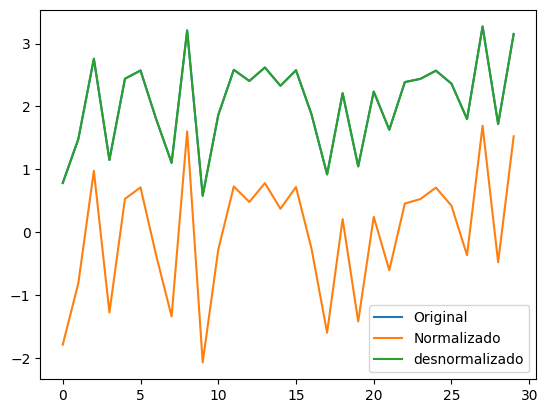

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.


Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:46:31.879822: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:46:31.923243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:46:31.923277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:46:31.924307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:46:31.929785: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:46:31.930609: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:46:32.936347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.662117,0.422434,0.443027,0.571570,0.129581,0.342868,0.390171,0.138313,0.202102,0.359974,0.318955,0.362775,134.086898,320.476637
model_1_0_8,0.621374,0.398871,0.431871,0.505800,0.145206,0.356856,0.397986,0.159547,0.211241,0.381059,0.236833,0.384025,133.859200,320.248939
model_1_0_7,0.525551,0.344046,0.377885,0.406093,0.181955,0.389403,0.435805,0.191736,0.241449,0.426562,0.043689,0.429882,133.407988,319.797727
model_1_0_6,0.457554,0.298559,0.331660,0.314103,0.208033,0.416406,0.468186,0.221434,0.257213,0.456106,-0.093367,0.459656,133.140119,319.529858
model_1_0_5,0.388855,0.265750,0.307488,0.207211,0.234380,0.435883,0.485119,0.255943,0.270202,0.484128,-0.231839,0.487895,132.901627,319.291367
model_1_0_4,0.375264,0.256312,0.298616,0.193060,0.239592,0.441485,0.491334,0.260511,0.273389,0.489481,-0.259233,0.493290,132.857638,319.247378
model_1_0_3,0.236830,0.153386,0.198096,-0.000101,0.292683,0.502587,0.561751,0.322871,0.296412,0.541001,-0.538265,0.545212,132.457333,318.847073
model_1_0_2,0.140835,0.081761,0.186496,-0.027435,0.329497,0.545106,0.569876,0.331695,0.318471,0.574019,-0.731754,0.578486,132.220374,318.610113
model_1_0_1,0.013290,-0.006819,0.163660,-0.302298,0.378412,0.597691,0.585874,0.420431,0.334746,0.615152,-0.988836,0.619939,131.943544,318.333283
model_1_0_0,-0.047184,-0.106135,-0.136792,-0.064396,0.401605,0.656649,0.796346,0.343628,0.367369,0.633723,-1.110731,0.638655,131.824575,318.214314


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  33
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  37
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.937246,0.594314,0.519561,0.939322,0.024067,0.240833,0.336558,0.021498,0.086004,0.155134,0.873512,0.156342,137.453858,323.843597
model_1_1_8,0.936553,0.593443,0.519829,0.938623,0.024332,0.241350,0.336370,0.021745,0.086281,0.155988,0.872115,0.157202,137.431892,323.821631
model_1_1_7,0.928463,0.583858,0.507288,0.931331,0.027435,0.247040,0.345155,0.024329,0.091294,0.165636,0.855808,0.166925,137.191861,323.581600
model_1_1_6,0.917356,0.570677,0.521966,0.915601,0.031695,0.254865,0.334873,0.029902,0.097897,0.178030,0.833422,0.179415,136.903222,323.292961
model_1_1_5,0.916212,0.569460,0.518886,0.914668,0.032133,0.255587,0.337030,0.030232,0.098408,0.179258,0.831116,0.180653,136.875725,323.265464
model_1_1_4,0.900995,0.546049,0.486541,0.900692,0.037969,0.269485,0.359689,0.035184,0.111392,0.194857,0.800443,0.196373,136.541958,322.931697
model_1_1_3,0.896612,0.542195,0.482481,0.897142,0.039650,0.271773,0.362533,0.036441,0.113753,0.199123,0.791609,0.200673,136.455325,322.845064
model_1_1_2,0.894818,0.539203,0.479006,0.895534,0.040338,0.273549,0.364967,0.037011,0.114699,0.200844,0.787993,0.202407,136.420911,322.810650
model_1_1_1,0.817811,0.495271,0.444816,0.817209,0.069871,0.299629,0.388918,0.064761,0.151160,0.264331,0.632776,0.266388,135.322210,321.711949
model_1_1_0,0.715966,0.445350,0.443671,0.711226,0.108930,0.329264,0.389720,0.102310,0.187853,0.330045,0.427494,0.332613,134.434107,320.823846


DataFrame salvo em ../results/metrics_1_1


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  11


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_8,0.969293,0.627765,0.563473,0.965921,0.011776,0.220975,0.305797,0.016640,0.059530,0.108519,0.938107,0.109363,138.883325,325.273064
model_1_2_7,0.968805,0.627070,0.562883,0.965268,0.011964,0.221387,0.306209,0.016959,0.060033,0.109378,0.937123,0.110229,138.851790,325.241529
model_1_2_9,0.972580,0.624783,0.561868,0.967859,0.010516,0.222745,0.306921,0.015694,0.056445,0.102546,0.944732,0.103344,139.109777,325.499516
model_1_2_6,0.964059,0.623268,0.558771,0.959444,0.013784,0.223644,0.309090,0.019803,0.064834,0.117404,0.927557,0.118317,138.568553,324.958292
model_1_2_5,0.961714,0.621363,0.554469,0.956982,0.014683,0.224776,0.312104,0.021005,0.066978,0.121173,0.922830,0.122116,138.442128,324.831867
model_1_2_4,0.957458,0.616613,0.549227,0.952140,0.016315,0.227595,0.315776,0.023369,0.070858,0.127731,0.914251,0.128725,138.231308,324.621047
model_1_2_3,0.949444,0.610325,0.536325,0.946980,0.019389,0.231328,0.324814,0.025889,0.076479,0.139243,0.898098,0.140327,137.886125,324.275864
model_1_2_2,0.948474,0.609273,0.534957,0.946003,0.019761,0.231953,0.325772,0.026366,0.077199,0.140573,0.896143,0.141667,137.848125,324.237865
model_1_2_1,0.944867,0.605509,0.531269,0.942765,0.021144,0.234187,0.328356,0.027947,0.079948,0.145409,0.888873,0.146541,137.712814,324.102553
model_1_2_0,0.943907,0.604554,0.530331,0.941834,0.021512,0.234754,0.329013,0.028401,0.080639,0.146671,0.886937,0.147812,137.678263,324.068002


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_6,0.985018,0.641310,0.600709,0.981349,0.005746,0.212934,0.279712,0.008816,0.041013,0.075801,0.969801,0.076391,140.318569,326.708308
model_1_3_7,0.985156,0.641110,0.601924,0.981236,0.005693,0.213053,0.278861,0.008869,0.040779,0.075452,0.970079,0.076039,140.337047,326.726786
model_1_3_9,0.987144,0.639910,0.602064,0.982133,0.004930,0.213765,0.278762,0.008446,0.038021,0.070217,0.974087,0.070764,140.624655,327.014394
model_1_3_8,0.986961,0.639727,0.601572,0.982011,0.005000,0.213874,0.279107,0.008503,0.038332,0.070714,0.973719,0.071264,140.596462,326.986201
model_1_3_5,0.981524,0.637430,0.600332,0.977514,0.007086,0.215237,0.279976,0.010629,0.045864,0.084177,0.962759,0.084832,139.899348,326.289087
model_1_3_4,0.980654,0.631489,0.589131,0.976459,0.007419,0.218764,0.287822,0.011128,0.047510,0.086136,0.961006,0.086806,139.807328,326.197067
model_1_3_3,0.978405,0.630933,0.586706,0.974557,0.008282,0.219094,0.289521,0.012026,0.050320,0.091006,0.956472,0.091714,139.587333,325.977072
model_1_3_2,0.976445,0.629550,0.570047,0.974388,0.009034,0.219915,0.301191,0.012106,0.052082,0.095045,0.952522,0.095785,139.413606,325.803345
model_1_3_1,0.976018,0.629020,0.568734,0.974047,0.009197,0.220230,0.302111,0.012267,0.052595,0.095904,0.951660,0.096650,139.377649,325.767388
model_1_3_0,0.975148,0.628549,0.568520,0.973277,0.009531,0.220509,0.302261,0.012631,0.053580,0.097626,0.949908,0.098386,139.306428,325.696168


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.989734,0.644480,0.609256,0.983990,0.003937,0.211052,0.273724,0.005853,0.033314,0.062746,0.979308,0.063234,141.074639,327.464378
model_1_4_2,0.989836,0.643977,0.610747,0.983804,0.003898,0.211351,0.272680,0.005921,0.033127,0.062433,0.979514,0.062919,141.094622,327.484362
model_1_4_1,0.989785,0.643943,0.609988,0.983872,0.003917,0.211371,0.273211,0.005897,0.033198,0.062590,0.979411,0.063077,141.084628,327.474367
model_1_4_4,0.990902,0.642938,0.611414,0.982263,0.003489,0.211968,0.272213,0.006485,0.030468,0.059069,0.981662,0.059528,141.316227,327.705966
model_1_4_5,0.991677,0.642889,0.614239,0.982514,0.003192,0.211997,0.270234,0.006393,0.028536,0.056499,0.983223,0.056938,141.494149,327.883889
model_1_4_7,0.992030,0.642823,0.613091,0.982574,0.003057,0.212035,0.271038,0.006371,0.027789,0.055287,0.983935,0.055717,141.580895,327.970634
model_1_4_8,0.992087,0.642573,0.612776,0.982434,0.003035,0.212184,0.271258,0.006422,0.027604,0.055087,0.984051,0.055516,141.595337,327.985076
model_1_4_9,0.992212,0.642541,0.613474,0.982635,0.002987,0.212203,0.270770,0.006349,0.027316,0.054652,0.984302,0.055077,141.627077,328.016816
model_1_4_6,0.991971,0.642450,0.613535,0.982801,0.003079,0.212257,0.270727,0.006288,0.027993,0.055491,0.983816,0.055923,141.566162,327.955901
model_1_4_3,0.989673,0.639898,0.606851,0.981194,0.003960,0.213772,0.275409,0.006876,0.033308,0.062932,0.979185,0.063422,141.062803,327.452542


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 53ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_4,0.995259,0.654811,0.618850,0.994579,0.001818,0.204919,0.267003,0.001832,0.020653,0.042639,0.990444,0.042971,142.619913,329.009652
model_1_5_5,0.995742,0.654606,0.622478,0.994852,0.001633,0.205041,0.264462,0.001739,0.019332,0.040411,0.991417,0.040726,142.834587,329.224326
model_1_5_6,0.995790,0.654459,0.622675,0.994882,0.001615,0.205128,0.264324,0.001729,0.019220,0.040183,0.991514,0.040496,142.857213,329.246953
model_1_5_7,0.995879,0.654027,0.623686,0.994954,0.001580,0.205385,0.263616,0.001705,0.019004,0.039755,0.991693,0.040064,142.900070,329.289809
model_1_5_3,0.994820,0.653877,0.618951,0.994581,0.001987,0.205474,0.266933,0.001831,0.021128,0.044570,0.989559,0.044917,142.442751,328.832491
model_1_5_8,0.995924,0.653792,0.623853,0.994989,0.001563,0.205524,0.263499,0.001693,0.018882,0.039539,0.991783,0.039847,142.921859,329.311599
model_1_5_9,0.996136,0.653087,0.623674,0.995038,0.001482,0.205942,0.263624,0.001677,0.018302,0.038496,0.992211,0.038796,143.028755,329.418494
model_1_5_2,0.994285,0.651143,0.618247,0.994268,0.002192,0.207096,0.267426,0.001937,0.022586,0.046817,0.988480,0.047182,142.246019,328.635758
model_1_5_1,0.993383,0.649419,0.617200,0.993594,0.002538,0.208120,0.268159,0.002165,0.024491,0.050375,0.986663,0.050767,141.953015,328.342754
model_1_5_0,0.992557,0.643523,0.613334,0.993257,0.002855,0.211620,0.270868,0.002278,0.026667,0.053428,0.984997,0.053843,141.717704,328.107443


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.996189,0.649194,0.624323,0.995979,0.001461,0.208253,0.263169,0.001844,0.017919,0.038228,0.992319,0.038526,143.056743,329.446483
model_1_6_2,0.996650,0.648459,0.624378,0.995867,0.001285,0.208690,0.263131,0.001895,0.016525,0.035841,0.993249,0.036120,143.314626,329.704365
model_1_6_1,0.996343,0.647996,0.624384,0.995989,0.001402,0.208965,0.263127,0.001840,0.017488,0.037450,0.992629,0.037741,143.139038,329.528777
model_1_6_3,0.996804,0.647200,0.622403,0.995851,0.001226,0.209437,0.264515,0.001903,0.015720,0.035012,0.993557,0.035285,143.408239,329.797979
model_1_6_4,0.995131,0.645963,0.621554,0.988511,0.001867,0.210172,0.265109,0.005269,0.017147,0.043214,0.990185,0.043551,142.566324,328.956063
model_1_6_5,0.995133,0.645346,0.621111,0.988417,0.001867,0.210538,0.265420,0.005312,0.017126,0.043205,0.990189,0.043542,142.567171,328.956910
model_1_6_9,0.995248,0.643533,0.616208,0.986229,0.001822,0.211614,0.268854,0.006315,0.016187,0.042691,0.990421,0.043023,142.615112,329.004851
model_1_6_6,0.995235,0.643490,0.617004,0.987338,0.001827,0.211640,0.268296,0.005807,0.016702,0.042747,0.990396,0.043079,142.609841,328.999580
model_1_6_8,0.995252,0.643070,0.616308,0.986397,0.001821,0.211889,0.268784,0.006238,0.016115,0.042670,0.990431,0.043002,142.617010,329.006749
model_1_6_7,0.995256,0.642435,0.615107,0.986594,0.001820,0.212266,0.269626,0.006148,0.016239,0.042656,0.990437,0.042988,142.618381,329.008120


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_2,0.995349,0.642196,0.615176,0.998757,0.001784,0.212408,0.269577,0.000548,0.015873,0.042234,0.990625,0.042562,142.658139,329.047879
model_1_7_1,0.995292,0.642167,0.614636,0.998782,0.001805,0.212425,0.269956,0.000537,0.015927,0.042491,0.990511,0.042821,142.633891,329.023631
model_1_7_0,0.995254,0.641909,0.614598,0.998812,0.001820,0.212579,0.269982,0.000524,0.015920,0.042664,0.990433,0.042996,142.617611,329.007350
model_1_7_3,0.995705,0.638236,0.607814,0.998236,0.001647,0.214759,0.274734,0.000778,0.016674,0.040585,0.991343,0.040901,142.817430,329.207169
model_1_7_4,0.997413,0.630107,0.613750,0.997720,0.000992,0.219585,0.270576,0.001006,0.014257,0.031499,0.994785,0.031744,143.831199,330.220938
model_1_7_5,0.997508,0.627005,0.612801,0.997550,0.000956,0.221426,0.271241,0.001081,0.014085,0.030912,0.994978,0.031152,143.906476,330.296215
model_1_7_6,0.997520,0.626694,0.612842,0.997533,0.000951,0.221610,0.271212,0.001088,0.014061,0.030841,0.995001,0.031081,143.915627,330.305366
model_1_7_7,0.997563,0.624331,0.613382,0.997424,0.000934,0.223014,0.270834,0.001136,0.013949,0.030569,0.995089,0.030806,143.951127,330.340866
model_1_7_8,0.997615,0.622882,0.613611,0.997332,0.000915,0.223873,0.270674,0.001177,0.013810,0.030244,0.995192,0.030480,143.993780,330.383520
model_1_7_9,0.997678,0.620473,0.614370,0.997200,0.000890,0.225304,0.270142,0.001235,0.013707,0.029840,0.995320,0.030072,144.047629,330.437368


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.996344,0.620958,0.616296,0.988391,0.001402,0.225015,0.268793,0.004012,0.015010,0.037444,0.992631,0.037736,143.139595,329.529335
model_1_8_9,0.995507,0.619152,0.629304,0.980659,0.001723,0.226088,0.259680,0.006684,0.015081,0.041510,0.990944,0.041833,142.727273,329.117012
model_1_8_1,0.996298,0.619066,0.612707,0.987740,0.001420,0.226139,0.271307,0.004237,0.015023,0.037682,0.992537,0.037975,143.114279,329.504019
model_1_8_4,0.996217,0.618195,0.618899,0.986175,0.001451,0.226656,0.266970,0.004778,0.014930,0.038088,0.992376,0.038384,143.071473,329.461212
model_1_8_8,0.995633,0.617580,0.628543,0.981640,0.001675,0.227021,0.260213,0.006345,0.015028,0.040923,0.991198,0.041242,142.784213,329.173952
model_1_8_3,0.996285,0.617270,0.614436,0.986906,0.001425,0.227205,0.270095,0.004525,0.014843,0.037744,0.992513,0.038038,143.107699,329.497438
model_1_8_2,0.996276,0.617100,0.614938,0.986910,0.001428,0.227306,0.269744,0.004524,0.014852,0.037790,0.992494,0.038084,143.102852,329.492591
model_1_8_7,0.995641,0.614909,0.627174,0.981895,0.001672,0.228607,0.261172,0.006257,0.015222,0.040888,0.991213,0.041206,142.787689,329.177429
model_1_8_5,0.995954,0.613973,0.614632,0.984127,0.001552,0.229162,0.269958,0.005486,0.015191,0.039393,0.991844,0.039699,142.936718,329.326457
model_1_8_6,0.995653,0.613828,0.626528,0.982247,0.001667,0.229248,0.261625,0.006135,0.015304,0.040830,0.991238,0.041148,142.793311,329.183050


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++

Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_5,0.996362,0.635797,0.623910,0.985085,0.001395,0.216207,0.263459,0.003930,0.015152,0.037351,0.992668,0.037642,143.149590,329.539330
model_1_9_6,0.996351,0.635654,0.622344,0.984946,0.001399,0.216292,0.264556,0.003967,0.015166,0.037408,0.992645,0.037699,143.143523,329.533262
model_1_9_9,0.996221,0.634916,0.632771,0.983201,0.001449,0.216730,0.257251,0.004427,0.015403,0.038071,0.992382,0.038367,143.073226,329.462965
model_1_9_7,0.996413,0.634859,0.628460,0.984951,0.001376,0.216763,0.260271,0.003965,0.015147,0.037089,0.992770,0.037378,143.177697,329.567436
model_1_9_8,0.996212,0.634562,0.633316,0.983161,0.001453,0.216940,0.256869,0.004437,0.015390,0.038117,0.992364,0.038414,143.068381,329.458120
model_1_9_4,0.996362,0.634242,0.617320,0.985928,0.001395,0.217130,0.268075,0.003708,0.015164,0.037354,0.992666,0.037645,143.149231,329.538971
model_1_9_3,0.996357,0.633836,0.617255,0.985950,0.001397,0.217371,0.268121,0.003702,0.015163,0.037377,0.992658,0.037667,143.146852,329.536592
model_1_9_2,0.996460,0.632517,0.614244,0.988057,0.001358,0.218154,0.270230,0.003147,0.015150,0.036848,0.992864,0.037135,143.203827,329.593566
model_1_9_1,0.995720,0.622639,0.628635,0.998031,0.001641,0.224018,0.260149,0.000519,0.015013,0.040512,0.991374,0.040827,142.824615,329.214354
model_1_9_0,0.995695,0.620550,0.627225,0.998231,0.001651,0.225258,0.261137,0.000466,0.014980,0.040631,0.991323,0.040947,142.812873,329.202612


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.996592,0.638634,0.625558,0.996030,0.001307,0.214522,0.262304,0.001818,0.015002,0.036152,0.993131,0.036434,143.280060,329.669799
model_1_10_9,0.997825,0.636055,0.603575,0.994496,0.000834,0.216053,0.277704,0.002521,0.012682,0.028884,0.995615,0.029108,144.177934,330.567674
model_1_10_8,0.997845,0.635343,0.604717,0.994898,0.000826,0.216476,0.276904,0.002337,0.012893,0.028746,0.995657,0.028970,144.197028,330.586767
model_1_10_6,0.997821,0.634751,0.605413,0.995167,0.000836,0.216828,0.276417,0.002214,0.013194,0.028911,0.995607,0.029136,144.174151,330.563890
model_1_10_1,0.997405,0.634712,0.618415,0.995379,0.000995,0.216851,0.267308,0.002117,0.014204,0.031544,0.994770,0.031790,143.825481,330.215220
model_1_10_5,0.997637,0.634669,0.608062,0.995145,0.000906,0.216876,0.274561,0.002224,0.013665,0.030101,0.995238,0.030335,144.012810,330.402549
model_1_10_4,0.997623,0.634561,0.608081,0.995135,0.000911,0.216940,0.274548,0.002229,0.013697,0.030190,0.995210,0.030425,144.001003,330.390742
model_1_10_3,0.997598,0.634405,0.605953,0.995308,0.000921,0.217033,0.276038,0.002149,0.013705,0.030351,0.995159,0.030587,143.979721,330.369460
model_1_10_7,0.997843,0.633967,0.604450,0.994989,0.000827,0.217293,0.277091,0.002296,0.013099,0.028763,0.995652,0.028987,144.194692,330.584432
model_1_10_2,0.997483,0.633641,0.616964,0.995346,0.000965,0.217486,0.268325,0.002132,0.014020,0.031069,0.994927,0.031311,143.886161,330.275901


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_3,0.997957,0.639553,0.631140,0.997805,0.000783,0.213977,0.258394,0.001128,0.012652,0.027990,0.995883,0.028207,144.303702,330.693441
model_1_11_2,0.997907,0.637418,0.618197,0.997853,0.000803,0.215245,0.267461,0.001103,0.012584,0.028331,0.995781,0.028552,144.255149,330.644888
model_1_11_0,0.997827,0.636376,0.604655,0.998007,0.000833,0.215863,0.276947,0.001024,0.012701,0.028866,0.995621,0.029091,144.180320,330.570059
model_1_11_1,0.997843,0.636285,0.606237,0.997981,0.000827,0.215917,0.275839,0.001037,0.012660,0.028765,0.995651,0.028989,144.194406,330.584145
model_1_11_4,0.998077,0.630237,0.637722,0.997626,0.000738,0.219507,0.253783,0.001220,0.012523,0.027159,0.996123,0.027371,144.424149,330.813888
model_1_11_6,0.998164,0.629933,0.648842,0.997482,0.000704,0.219688,0.245994,0.001294,0.012344,0.026532,0.996300,0.026739,144.517553,330.907293
model_1_11_7,0.998187,0.629588,0.654915,0.997412,0.000695,0.219892,0.241739,0.001330,0.012332,0.026369,0.996346,0.026574,144.542287,330.932026
model_1_11_5,0.998072,0.628904,0.638392,0.997533,0.000739,0.220299,0.253314,0.001267,0.012629,0.027189,0.996115,0.027400,144.419808,330.809547
model_1_11_8,0.998220,0.628520,0.654515,0.997453,0.000682,0.220527,0.242020,0.001309,0.012365,0.026124,0.996413,0.026327,144.579611,330.969351
model_1_11_9,0.998227,0.627284,0.653598,0.997320,0.000680,0.221260,0.242661,0.001377,0.012398,0.026080,0.996425,0.026283,144.586410,330.976149


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  34
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_4,0.997968,0.633573,0.667625,0.996255,0.000779,0.217527,0.232835,0.001817,0.013003,0.027919,0.995903,0.028136,144.313860,330.703599
model_1_12_3,0.998113,0.633434,0.667299,0.996905,0.000724,0.217609,0.233064,0.001502,0.012689,0.026904,0.996196,0.027113,144.461924,330.851663
model_1_12_5,0.998011,0.633413,0.667790,0.996424,0.000763,0.217622,0.232720,0.001735,0.012890,0.027621,0.995990,0.027836,144.356710,330.746449
model_1_12_1,0.998329,0.633025,0.659725,0.998284,0.000641,0.217852,0.238370,0.000833,0.012396,0.025313,0.996632,0.025510,144.705703,331.095442
model_1_12_0,0.998302,0.632722,0.656625,0.998514,0.000651,0.218032,0.240541,0.000721,0.012425,0.025519,0.996577,0.025718,144.673282,331.063021
model_1_12_2,0.998179,0.631781,0.664110,0.997330,0.000698,0.218590,0.235298,0.001295,0.012618,0.026427,0.996329,0.026633,144.533498,330.923237
model_1_12_7,0.997787,0.629069,0.670273,0.995243,0.000849,0.220201,0.230981,0.002308,0.013069,0.029136,0.995538,0.029362,144.143168,330.532907
model_1_12_6,0.997791,0.628958,0.670139,0.995274,0.000847,0.220267,0.231075,0.002293,0.013066,0.029104,0.995548,0.029331,144.147480,330.537219
model_1_12_8,0.997776,0.628360,0.670077,0.995164,0.000853,0.220622,0.231118,0.002346,0.013095,0.029204,0.995518,0.029431,144.133850,330.523589
model_1_12_9,0.997637,0.626327,0.671017,0.994535,0.000906,0.221828,0.230459,0.002651,0.013251,0.030103,0.995237,0.030337,144.012582,330.402321


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.996440,0.627434,0.653790,0.983929,0.001365,0.221171,0.242527,0.004516,0.014370,0.036951,0.992824,0.037239,143.192643,329.582382
model_1_13_7,0.996598,0.626149,0.663656,0.985821,0.001305,0.221934,0.235616,0.003984,0.014433,0.036118,0.993144,0.036399,143.283813,329.673552
model_1_13_8,0.996597,0.626105,0.661000,0.985551,0.001305,0.221960,0.237477,0.004060,0.014339,0.036124,0.993142,0.036405,143.283208,329.672947
model_1_13_0,0.997618,0.626078,0.671383,0.998053,0.000913,0.221976,0.230203,0.000547,0.013313,0.030221,0.995200,0.030457,143.996808,330.386548
model_1_13_6,0.996608,0.625710,0.664944,0.986055,0.001301,0.222195,0.234714,0.003918,0.014463,0.036066,0.993163,0.036347,143.289564,329.679304
model_1_13_5,0.996613,0.625236,0.666116,0.986136,0.001299,0.222476,0.233893,0.003896,0.014450,0.036043,0.993172,0.036324,143.292169,329.681908
model_1_13_2,0.996718,0.625007,0.670295,0.987880,0.001259,0.222612,0.230965,0.003406,0.014451,0.035476,0.993385,0.035753,143.355540,329.745279
model_1_13_3,0.996720,0.624926,0.669896,0.987609,0.001258,0.222660,0.231245,0.003482,0.014409,0.035469,0.993388,0.035745,143.356440,329.746180
model_1_13_4,0.996681,0.624232,0.668098,0.986832,0.001273,0.223072,0.232504,0.003700,0.014403,0.035676,0.993310,0.035954,143.333072,329.722811
model_1_13_1,0.996833,0.623864,0.671182,0.988793,0.001214,0.223291,0.230344,0.003149,0.014404,0.034849,0.993617,0.035121,143.426874,329.816613


DataFrame salvo em ../results/metrics_1_13


+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_3,0.995728,0.628038,0.650325,0.990518,0.001639,0.220813,0.244955,0.004979,0.015446,0.040479,0.991388,0.040794,142.827909,329.217649
model_1_14_5,0.996477,0.627525,0.644578,0.991729,0.001351,0.221117,0.248981,0.004343,0.013917,0.036756,0.992899,0.037042,143.213823,329.603562
model_1_14_6,0.996464,0.627215,0.644838,0.991632,0.001356,0.221301,0.248798,0.004394,0.013895,0.036827,0.992872,0.037114,143.206074,329.595814
model_1_14_8,0.996410,0.627189,0.643774,0.991248,0.001377,0.221317,0.249543,0.004595,0.013854,0.037103,0.992765,0.037392,143.176249,329.565988
model_1_14_1,0.996459,0.627025,0.652706,0.997622,0.001358,0.221414,0.243286,0.001248,0.014726,0.036851,0.992863,0.037137,143.203523,329.593262
model_1_14_2,0.994841,0.627009,0.652100,0.987595,0.001978,0.221424,0.243711,0.006514,0.016259,0.044479,0.989602,0.044825,142.450968,328.840707
model_1_14_7,0.996397,0.626829,0.644151,0.991212,0.001382,0.221530,0.249279,0.004615,0.013912,0.037174,0.992737,0.037463,143.168625,329.558364
model_1_14_9,0.996490,0.625403,0.644596,0.991445,0.001346,0.222377,0.248968,0.004492,0.013792,0.036687,0.992926,0.036973,143.221309,329.611048
model_1_14_0,0.996395,0.625035,0.655983,0.997500,0.001382,0.222595,0.240991,0.001313,0.014615,0.037181,0.992734,0.037470,143.167863,329.557602
model_1_14_4,0.996843,0.623592,0.648076,0.993577,0.001211,0.223452,0.246530,0.003373,0.014470,0.034795,0.993637,0.035066,143.433131,329.822870


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_1,0.996799,0.627333,0.638590,0.991560,0.001228,0.221231,0.253175,0.003009,0.013173,0.035039,0.993547,0.035312,143.405152,329.794891
model_1_15_2,0.996834,0.627259,0.638244,0.991670,0.001214,0.221275,0.253417,0.002969,0.013188,0.034843,0.993620,0.035114,143.427663,329.817403
model_1_15_4,0.997166,0.626915,0.634953,0.992577,0.001087,0.221480,0.255723,0.002646,0.013377,0.032969,0.994287,0.033225,143.648782,330.038521
model_1_15_0,0.996634,0.626710,0.643577,0.991594,0.001291,0.221601,0.249682,0.002996,0.013550,0.035928,0.993216,0.036207,143.304994,329.694734
model_1_15_3,0.996994,0.626575,0.632114,0.991881,0.001153,0.221681,0.257712,0.002894,0.013132,0.033951,0.993942,0.034215,143.531399,329.921138
model_1_15_7,0.997441,0.625829,0.635649,0.993505,0.000981,0.222124,0.255236,0.002315,0.013197,0.031326,0.994842,0.031570,143.853227,330.242966
model_1_15_5,0.997321,0.625750,0.635176,0.993115,0.001027,0.222171,0.255567,0.002454,0.013315,0.032054,0.994600,0.032303,143.761358,330.151097
model_1_15_6,0.997338,0.625726,0.635297,0.993159,0.001021,0.222185,0.255482,0.002439,0.013284,0.031950,0.994635,0.032199,143.774299,330.164038
model_1_15_8,0.997450,0.625243,0.634935,0.993527,0.000978,0.222472,0.255736,0.002307,0.013217,0.031275,0.994859,0.031518,143.859760,330.249500
model_1_15_9,0.997686,0.623830,0.636650,0.994188,0.000887,0.223311,0.254534,0.002072,0.012737,0.029787,0.995337,0.030019,144.054715,330.444454


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,0.994776,0.630619,0.639586,0.976775,0.002004,0.219281,0.252478,0.008267,0.015429,0.044762,0.989470,0.045110,142.425627,328.815366
model_1_16_8,0.994766,0.630303,0.639672,0.976728,0.002007,0.219468,0.252417,0.008284,0.015418,0.044804,0.989449,0.045153,142.421801,328.811541
model_1_16_7,0.995289,0.630046,0.639320,0.979564,0.001807,0.219621,0.252664,0.007274,0.015088,0.042505,0.990505,0.042836,142.632552,329.022291
model_1_16_6,0.994778,0.629920,0.640432,0.976910,0.002003,0.219695,0.251885,0.008219,0.015437,0.044753,0.989473,0.045102,142.426360,328.816099
model_1_16_3,0.997361,0.628621,0.637299,0.991365,0.001012,0.220467,0.254079,0.003074,0.013249,0.031812,0.994681,0.032060,143.791625,330.181364
model_1_16_5,0.996376,0.627656,0.640155,0.985802,0.001390,0.221040,0.252079,0.005054,0.014298,0.037282,0.992695,0.037572,143.156953,329.546692
model_1_16_4,0.995423,0.627274,0.638541,0.980799,0.001755,0.221266,0.253209,0.006835,0.014979,0.041898,0.990774,0.042224,142.690079,329.079818
model_1_16_2,0.997627,0.624476,0.634550,0.993232,0.000910,0.222927,0.256005,0.002409,0.012740,0.030165,0.995218,0.030400,144.004233,330.393972
model_1_16_1,0.997637,0.624313,0.633799,0.993322,0.000906,0.223024,0.256532,0.002377,0.012857,0.030103,0.995237,0.030337,144.012572,330.402311
model_1_16_0,0.995845,0.623488,0.633486,0.983753,0.001593,0.223514,0.256751,0.005783,0.014608,0.039917,0.991626,0.040228,142.883801,329.273541


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  38
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 1s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_2,0.996602,0.634891,0.644730,0.988707,0.001303,0.216744,0.248874,0.004034,0.014447,0.036097,0.993152,0.036378,143.286197,329.675937
model_1_17_3,0.996935,0.633836,0.649169,0.990113,0.001175,0.217371,0.245764,0.003532,0.014134,0.034284,0.993823,0.034551,143.492335,329.882074
model_1_17_1,0.995457,0.633704,0.646226,0.983270,0.001742,0.217449,0.247826,0.005977,0.015293,0.041740,0.990843,0.042064,142.705215,329.094954
model_1_17_0,0.994823,0.630335,0.639910,0.980757,0.001985,0.219449,0.252250,0.006875,0.015387,0.044558,0.989565,0.044905,142.443833,328.833572
model_1_17_4,0.997410,0.626933,0.648889,0.991841,0.000993,0.221468,0.245960,0.002915,0.013572,0.031519,0.994779,0.031764,143.828684,330.218423
model_1_17_5,0.997406,0.626742,0.647291,0.991771,0.000995,0.221582,0.247080,0.002940,0.013558,0.031543,0.994771,0.031789,143.825596,330.215336
model_1_17_6,0.997433,0.626497,0.646983,0.991878,0.000985,0.221728,0.247296,0.002902,0.013527,0.031378,0.994825,0.031622,143.846562,330.236302
model_1_17_8,0.997478,0.626137,0.647236,0.992063,0.000967,0.221942,0.247118,0.002836,0.013480,0.031098,0.994917,0.031340,143.882470,330.272209
model_1_17_7,0.997470,0.625741,0.647797,0.992026,0.000970,0.222176,0.246726,0.002849,0.013491,0.031146,0.994901,0.031389,143.876238,330.265977
model_1_17_9,0.997539,0.624662,0.644742,0.992284,0.000944,0.222817,0.248865,0.002756,0.013287,0.030723,0.995039,0.030962,143.931038,330.320778


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_6,0.993377,0.627766,0.662585,0.970913,0.002540,0.220974,0.236366,0.010532,0.014677,0.050397,0.986651,0.050789,141.951275,328.341014
model_1_18_5,0.993020,0.626557,0.664823,0.969145,0.002677,0.221692,0.234798,0.011172,0.014778,0.051740,0.985930,0.052142,141.846112,328.235852
model_1_18_3,0.992998,0.626064,0.664169,0.969096,0.002685,0.221985,0.235257,0.011190,0.014878,0.051819,0.985887,0.052223,141.839957,328.229696
model_1_18_4,0.993063,0.625957,0.663754,0.969407,0.002660,0.222048,0.235547,0.011078,0.014848,0.051579,0.986017,0.051981,141.858529,328.248268
model_1_18_2,0.992953,0.625778,0.662172,0.969182,0.002703,0.222154,0.236656,0.011159,0.015085,0.051986,0.985796,0.052391,141.827108,328.216848
model_1_18_9,0.992863,0.625719,0.668927,0.967706,0.002737,0.222189,0.231923,0.011694,0.014269,0.052319,0.985613,0.052726,141.801573,328.191313
model_1_18_8,0.993450,0.625506,0.661067,0.971100,0.002512,0.222316,0.237430,0.010465,0.014568,0.050120,0.986797,0.050510,141.973339,328.363078
model_1_18_0,0.997729,0.625201,0.649414,0.997389,0.000871,0.222497,0.245593,0.000945,0.013411,0.029513,0.995422,0.029742,144.091759,330.481498
model_1_18_1,0.993235,0.625065,0.659998,0.971366,0.002594,0.222578,0.238179,0.010368,0.015102,0.050935,0.986365,0.051332,141.908802,328.298541
model_1_18_7,0.993766,0.623705,0.658139,0.972954,0.002391,0.223385,0.239480,0.009793,0.014673,0.048894,0.987435,0.049275,142.072374,328.462113


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  42
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_3,0.994772,0.646254,0.648164,0.996892,0.002005,0.209999,0.246469,0.001564,0.015000,0.044775,0.989463,0.045123,142.424420,328.814159
model_1_19_4,0.995315,0.644421,0.636985,0.996878,0.001797,0.211087,0.254300,0.001572,0.015778,0.042387,0.990557,0.042717,142.643653,329.033392
model_1_19_2,0.994491,0.644022,0.652582,0.996895,0.002113,0.211324,0.243374,0.001563,0.015121,0.045963,0.988897,0.046321,142.319675,328.709414
model_1_19_1,0.994027,0.643466,0.656144,0.997400,0.002291,0.211654,0.240878,0.001309,0.015098,0.047861,0.987961,0.048234,142.157807,328.547547
model_1_19_7,0.997004,0.641649,0.591452,0.997168,0.001149,0.212733,0.286196,0.001425,0.014524,0.033894,0.993962,0.034158,143.538027,329.927766
model_1_19_5,0.996865,0.641262,0.592011,0.997234,0.001202,0.212962,0.285805,0.001392,0.014853,0.034675,0.993681,0.034945,143.446975,329.836715
model_1_19_6,0.996904,0.641157,0.593485,0.997277,0.001187,0.213024,0.284772,0.001371,0.014778,0.034456,0.993760,0.034724,143.472281,329.862021
model_1_19_8,0.997011,0.640975,0.593754,0.997093,0.001146,0.213133,0.284583,0.001464,0.014617,0.033854,0.993976,0.034118,143.542749,329.932488
model_1_19_0,0.993893,0.639032,0.658629,0.997271,0.002342,0.214286,0.239137,0.001374,0.015293,0.048396,0.987690,0.048773,142.113332,328.503071
model_1_19_9,0.997331,0.636892,0.572402,0.997133,0.001023,0.215557,0.299541,0.001443,0.014518,0.031992,0.994621,0.032241,143.769066,330.158805


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.997362,0.640558,0.571334,0.998250,0.001012,0.213380,0.300289,0.000679,0.014273,0.031805,0.994683,0.032053,143.792504,330.182243
model_1_20_1,0.997373,0.640148,0.569879,0.998170,0.001007,0.213624,0.301309,0.000710,0.014253,0.031739,0.994706,0.031986,143.800847,330.190586
model_1_20_2,0.997434,0.635912,0.562154,0.998120,0.000984,0.216138,0.306720,0.000730,0.014312,0.031371,0.994828,0.031615,143.847444,330.237183
model_1_20_3,0.997458,0.635758,0.561185,0.998128,0.000975,0.216230,0.307399,0.000727,0.014261,0.031226,0.994875,0.031469,143.866073,330.255812
model_1_20_4,0.997527,0.634270,0.554111,0.998037,0.000949,0.217113,0.312355,0.000762,0.014192,0.030799,0.995015,0.031038,143.921122,330.310861
model_1_20_5,0.997552,0.634036,0.553092,0.998065,0.000939,0.217252,0.313068,0.000751,0.014136,0.030638,0.995066,0.030876,143.942051,330.331790
model_1_20_6,0.997713,0.632649,0.539156,0.998069,0.000877,0.218075,0.322831,0.000749,0.013816,0.029613,0.995391,0.029844,144.078126,330.467865
model_1_20_7,0.997723,0.632457,0.538151,0.998038,0.000873,0.218190,0.323535,0.000762,0.013808,0.029550,0.995411,0.029780,144.086652,330.476391
model_1_20_8,0.997784,0.630468,0.531959,0.997922,0.000850,0.219370,0.327872,0.000806,0.013683,0.029150,0.995534,0.029377,144.141210,330.530949
model_1_20_9,0.997791,0.630100,0.530514,0.997884,0.000847,0.219589,0.328885,0.000821,0.013684,0.029105,0.995548,0.029331,144.147415,330.537154


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  35
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  34
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_5,0.997381,0.629050,0.512070,0.989567,0.001004,0.220212,0.341805,0.002666,0.013224,0.031690,0.994722,0.031936,143.807074,330.196814
model_1_21_3,0.997819,0.628139,0.513636,0.993740,0.000836,0.220753,0.340708,0.001600,0.013264,0.028921,0.995604,0.029147,144.172683,330.562422
model_1_21_0,0.997913,0.628133,0.524760,0.997043,0.000800,0.220756,0.332916,0.000756,0.013384,0.028291,0.995793,0.028512,144.260783,330.650522
model_1_21_1,0.997923,0.627882,0.523500,0.997013,0.000796,0.220905,0.333798,0.000763,0.013351,0.028221,0.995814,0.028441,144.270691,330.660430
model_1_21_2,0.997853,0.627472,0.512100,0.994292,0.000823,0.221149,0.341784,0.001459,0.013292,0.028697,0.995672,0.028920,144.203905,330.593645
model_1_21_4,0.997629,0.627312,0.508358,0.991867,0.000909,0.221244,0.344406,0.002078,0.013242,0.030152,0.995222,0.030387,144.005996,330.395735
model_1_21_6,0.995921,0.626153,0.499158,0.977965,0.001564,0.221932,0.350850,0.005631,0.013545,0.039552,0.991778,0.039860,142.920536,329.310275
model_1_21_7,0.995793,0.624681,0.492829,0.976879,0.001613,0.222806,0.355284,0.005909,0.013553,0.040166,0.991521,0.040479,142.858913,329.248652
model_1_21_8,0.995680,0.623970,0.486818,0.975732,0.001657,0.223227,0.359495,0.006202,0.013468,0.040702,0.991293,0.041019,142.805926,329.195665
model_1_21_9,0.995406,0.622291,0.482947,0.973527,0.001762,0.224224,0.362207,0.006765,0.013480,0.041973,0.990741,0.042300,142.682872,329.072612


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_5,0.996498,0.633005,0.587119,0.994537,0.001343,0.217864,0.289231,0.001871,0.015857,0.036647,0.992941,0.036932,143.225686,329.615425
model_1_22_6,0.996517,0.632735,0.602022,0.993946,0.001336,0.218025,0.278792,0.002073,0.015685,0.036549,0.992979,0.036834,143.236391,329.626130
model_1_22_4,0.996447,0.632610,0.589525,0.994436,0.001362,0.218098,0.287547,0.001906,0.015957,0.036912,0.992839,0.037199,143.196886,329.586625
model_1_22_7,0.996505,0.631841,0.603049,0.993855,0.001340,0.218555,0.278073,0.002105,0.015805,0.036612,0.992955,0.036897,143.229533,329.619272
model_1_22_8,0.996912,0.631018,0.645369,0.993380,0.001184,0.219044,0.248427,0.002267,0.014169,0.034416,0.993775,0.034684,143.476944,329.866684
model_1_22_9,0.996976,0.630155,0.648947,0.993412,0.001160,0.219556,0.245920,0.002256,0.014062,0.034054,0.993905,0.034319,143.519273,329.909012
model_1_22_0,0.996417,0.626842,0.559329,0.995978,0.001374,0.221523,0.308699,0.001377,0.013959,0.037069,0.992778,0.037358,143.179866,329.569606
model_1_22_3,0.996469,0.625275,0.569031,0.994797,0.001354,0.222453,0.301902,0.001782,0.014599,0.036797,0.992884,0.037083,143.209370,329.599109
model_1_22_2,0.996379,0.625159,0.576729,0.994588,0.001389,0.222522,0.296510,0.001854,0.014609,0.037264,0.992702,0.037554,143.158920,329.548659
model_1_22_1,0.996341,0.624696,0.577659,0.994553,0.001403,0.222796,0.295858,0.001866,0.014652,0.037459,0.992625,0.037750,143.138053,329.527792


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_6,0.997984,0.635857,0.654110,0.996176,0.000773,0.216171,0.242303,0.001265,0.012431,0.027805,0.995937,0.028021,144.330191,330.719930
model_1_23_8,0.998040,0.635628,0.653149,0.996126,0.000752,0.216307,0.242977,0.001281,0.012267,0.027419,0.996049,0.027633,144.386014,330.775753
model_1_23_7,0.998030,0.635226,0.653240,0.996142,0.000756,0.216546,0.242912,0.001276,0.012300,0.027489,0.996029,0.027702,144.375941,330.765681
model_1_23_5,0.997789,0.635166,0.647087,0.996020,0.000848,0.216581,0.247223,0.001316,0.012947,0.029121,0.995543,0.029348,144.145120,330.534859
model_1_23_9,0.998043,0.633624,0.652122,0.996139,0.000751,0.217497,0.243696,0.001277,0.012273,0.027398,0.996055,0.027611,144.389190,330.778929
model_1_23_4,0.997500,0.631819,0.640028,0.995971,0.000959,0.218568,0.252168,0.001333,0.013613,0.030964,0.994961,0.031205,143.899777,330.289516
model_1_23_0,0.997226,0.629588,0.652839,0.995964,0.001064,0.219893,0.243194,0.001335,0.013854,0.032617,0.994409,0.032870,143.691743,330.081483
model_1_23_2,0.997349,0.628602,0.652613,0.995995,0.001017,0.220478,0.243352,0.001325,0.013652,0.031884,0.994657,0.032132,143.782598,330.172338
model_1_23_1,0.997332,0.628276,0.652919,0.995998,0.001023,0.220671,0.243137,0.001324,0.013677,0.031986,0.994623,0.032235,143.769801,330.159540
model_1_23_3,0.997391,0.626806,0.646609,0.996010,0.001001,0.221544,0.247558,0.001320,0.013592,0.031634,0.994740,0.031881,143.814038,330.203777


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_1,0.996562,0.633799,0.654067,0.991572,0.001319,0.217393,0.242333,0.003483,0.013710,0.036312,0.993070,0.036595,143.262437,329.652176
model_1_24_3,0.996611,0.633455,0.662752,0.991085,0.001300,0.217597,0.236249,0.003685,0.013587,0.036052,0.993169,0.036332,143.291196,329.680935
model_1_24_0,0.997951,0.633094,0.650957,0.998513,0.000786,0.217811,0.244512,0.000614,0.012636,0.028036,0.995869,0.028254,144.297106,330.686845
model_1_24_5,0.996508,0.632693,0.669374,0.990346,0.001339,0.218049,0.231611,0.003991,0.013762,0.036594,0.992962,0.036879,143.231513,329.621252
model_1_24_9,0.996388,0.632549,0.672485,0.989226,0.001385,0.218135,0.229431,0.004453,0.013839,0.037219,0.992719,0.037509,143.163752,329.553491
model_1_24_4,0.996508,0.632417,0.668659,0.990466,0.001339,0.218213,0.232112,0.003941,0.013805,0.036594,0.992962,0.036879,143.231508,329.621248
model_1_24_2,0.996612,0.631624,0.660645,0.991413,0.001299,0.218684,0.237725,0.003549,0.013678,0.036046,0.993171,0.036326,143.291868,329.681607
model_1_24_8,0.996425,0.631485,0.673308,0.989603,0.001371,0.218766,0.228855,0.004298,0.013881,0.037029,0.992794,0.037317,143.184224,329.573963
model_1_24_7,0.996432,0.631449,0.670623,0.989692,0.001368,0.218788,0.230735,0.004261,0.013880,0.036989,0.992809,0.037277,143.188528,329.578267
model_1_24_6,0.996430,0.630047,0.670223,0.989712,0.001369,0.219620,0.231015,0.004252,0.013909,0.037002,0.992804,0.037290,143.187117,329.576856


DataFrame salvo em ../results/metrics_1_24


+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.998021,0.629651,0.675041,0.996970,0.000759,0.219855,0.227641,0.001427,0.012720,0.027548,0.996011,0.027762,144.367323,330.757062
model_1_25_1,0.997976,0.628297,0.677993,0.996666,0.000776,0.220659,0.225573,0.001570,0.012732,0.027864,0.995919,0.028081,144.321708,330.711447
model_1_25_2,0.997970,0.627377,0.679305,0.996604,0.000779,0.221205,0.224654,0.001599,0.012741,0.027904,0.995908,0.028122,144.315887,330.705626
model_1_25_3,0.997790,0.626990,0.679914,0.995731,0.000848,0.221435,0.224227,0.002010,0.013002,0.029114,0.995545,0.029340,144.146172,330.535911
model_1_25_4,0.997612,0.624961,0.682366,0.994875,0.000916,0.222639,0.222509,0.002414,0.013077,0.030261,0.995187,0.030497,143.991535,330.381275
model_1_25_5,0.997479,0.622495,0.685513,0.994254,0.000967,0.224103,0.220305,0.002706,0.013169,0.031095,0.994918,0.031337,143.882810,330.272549
model_1_25_6,0.995760,0.617852,0.688970,0.987048,0.001626,0.226859,0.217883,0.006100,0.014408,0.040327,0.991453,0.040641,142.842964,329.232704
model_1_25_7,0.995570,0.614315,0.690196,0.986167,0.001699,0.228959,0.217024,0.006515,0.014456,0.041218,0.991071,0.041539,142.755492,329.145231
model_1_25_8,0.995373,0.612956,0.690655,0.985259,0.001775,0.229766,0.216702,0.006943,0.014547,0.042126,0.990673,0.042454,142.668329,329.058069
model_1_25_9,0.995217,0.609012,0.693814,0.984597,0.001834,0.232108,0.214490,0.007255,0.014545,0.042828,0.990360,0.043161,142.602267,328.992006


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_4,0.997306,0.616703,0.710056,0.995018,0.001033,0.227542,0.203112,0.001532,0.013465,0.032145,0.994569,0.032395,143.749968,330.139708
model_1_26_5,0.997318,0.616629,0.710231,0.994979,0.001028,0.227585,0.202989,0.001544,0.013475,0.032069,0.994595,0.032319,143.759467,330.149206
model_1_26_6,0.997339,0.616470,0.710159,0.994978,0.001020,0.227680,0.203040,0.001544,0.013453,0.031945,0.994637,0.032193,143.775013,330.164752
model_1_26_9,0.997465,0.614330,0.711226,0.994790,0.000972,0.228951,0.202292,0.001602,0.013433,0.031180,0.994890,0.031422,143.871945,330.261685
model_1_26_7,0.997442,0.613806,0.711012,0.994826,0.000981,0.229261,0.202442,0.001591,0.013424,0.031320,0.994844,0.031564,143.853994,330.243733
model_1_26_3,0.997047,0.613566,0.704631,0.995753,0.001132,0.229404,0.206912,0.001306,0.013312,0.033652,0.994048,0.033913,143.566779,329.956518
model_1_26_2,0.997021,0.613296,0.704349,0.995776,0.001142,0.229564,0.207109,0.001299,0.013328,0.033799,0.993996,0.034062,143.549305,329.939044
model_1_26_8,0.997456,0.613010,0.710873,0.994838,0.000976,0.229734,0.202540,0.001587,0.013428,0.031235,0.994872,0.031479,143.864810,330.254549
model_1_26_1,0.996996,0.612986,0.704480,0.995785,0.001152,0.229748,0.207018,0.001296,0.013312,0.033940,0.993946,0.034204,143.532657,329.922397
model_1_26_0,0.995201,0.610925,0.699080,0.996087,0.001840,0.230972,0.210800,0.001203,0.014597,0.042899,0.990328,0.043232,142.595673,328.985412


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_6,0.998105,0.617169,0.711050,0.997373,0.000727,0.227265,0.202416,0.000970,0.012724,0.026961,0.996180,0.027171,144.453421,330.843160
model_1_27_3,0.997579,0.616445,0.710615,0.995819,0.000928,0.227695,0.202720,0.001543,0.013330,0.030471,0.995120,0.030708,143.963944,330.353683
model_1_27_2,0.997559,0.616270,0.710565,0.995787,0.000936,0.227798,0.202755,0.001555,0.013355,0.030599,0.995079,0.030837,143.947152,330.336891
model_1_27_8,0.998136,0.616125,0.710201,0.997474,0.000715,0.227885,0.203010,0.000932,0.012657,0.026740,0.996242,0.026948,144.486416,330.876155
model_1_27_9,0.998163,0.616084,0.709172,0.997516,0.000705,0.227909,0.203731,0.000917,0.012580,0.026546,0.996296,0.026753,144.515495,330.905234
model_1_27_7,0.998125,0.615464,0.710812,0.997453,0.000719,0.228277,0.202582,0.000940,0.012689,0.026814,0.996221,0.027023,144.475316,330.865055
model_1_27_1,0.997539,0.614986,0.710766,0.995762,0.000944,0.228561,0.202615,0.001564,0.013378,0.030720,0.995040,0.030959,143.931343,330.321082
model_1_27_0,0.997512,0.614784,0.711042,0.995679,0.000954,0.228681,0.202421,0.001595,0.013409,0.030889,0.994985,0.031129,143.909423,330.299163
model_1_27_5,0.997985,0.613395,0.709050,0.997185,0.000773,0.229506,0.203816,0.001039,0.012894,0.027802,0.995938,0.028018,144.330607,330.720346
model_1_27_4,0.997908,0.612675,0.707308,0.997050,0.000802,0.229933,0.205037,0.001089,0.012965,0.028325,0.995783,0.028545,144.256061,330.645801


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_8,0.998191,0.621029,0.701728,0.996864,0.000694,0.224973,0.208946,0.000911,0.012630,0.026341,0.996353,0.026546,144.546480,330.936219
model_1_28_7,0.998189,0.621017,0.701777,0.996901,0.000695,0.224981,0.208911,0.000900,0.012645,0.026354,0.996350,0.026559,144.544512,330.934252
model_1_28_9,0.998187,0.620727,0.701822,0.996812,0.000695,0.225153,0.208880,0.000926,0.012642,0.026368,0.996346,0.026573,144.542393,330.932132
model_1_28_5,0.998184,0.619857,0.702482,0.996926,0.000697,0.225669,0.208418,0.000893,0.012679,0.026393,0.996339,0.026598,144.538640,330.928379
model_1_28_6,0.998187,0.619838,0.702356,0.996900,0.000695,0.225680,0.208505,0.000901,0.012659,0.026365,0.996347,0.026571,144.542804,330.932544
model_1_28_3,0.998192,0.619500,0.702835,0.997069,0.000693,0.225881,0.208170,0.000851,0.012662,0.026330,0.996356,0.026535,144.548223,330.937962
model_1_28_4,0.998193,0.619154,0.702828,0.997031,0.000693,0.226087,0.208175,0.000863,0.012662,0.026327,0.996357,0.026532,144.548608,330.938347
model_1_28_2,0.998196,0.618717,0.704074,0.997455,0.000692,0.226346,0.207303,0.000739,0.012650,0.026306,0.996363,0.026511,144.551844,330.941583
model_1_28_0,0.998171,0.616770,0.708623,0.998518,0.000701,0.227502,0.204116,0.000430,0.012533,0.026481,0.996314,0.026687,144.525278,330.915017
model_1_28_1,0.998209,0.615391,0.706040,0.998244,0.000687,0.228321,0.205925,0.000510,0.012519,0.026210,0.996389,0.026414,144.566416,330.956155


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 1s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  20
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_8,0.998067,0.622029,0.700769,0.994113,0.000741,0.224380,0.209617,0.001593,0.012846,0.027227,0.996104,0.027439,144.414171,330.803910
model_1_29_7,0.998065,0.620673,0.702720,0.994659,0.000742,0.225185,0.208250,0.001445,0.012849,0.027244,0.996099,0.027456,144.411738,330.801477
model_1_29_6,0.998062,0.620576,0.702861,0.994694,0.000743,0.225242,0.208152,0.001436,0.012864,0.027265,0.996093,0.027477,144.408631,330.798370
model_1_29_9,0.998060,0.620052,0.700343,0.993725,0.000744,0.225553,0.209916,0.001698,0.012749,0.027274,0.996090,0.027486,144.407277,330.797016
model_1_29_0,0.998179,0.619778,0.702215,0.996996,0.000698,0.225716,0.208604,0.000813,0.012673,0.026428,0.996329,0.026634,144.533258,330.922997
model_1_29_5,0.998047,0.618370,0.703351,0.994898,0.000749,0.226552,0.207809,0.001381,0.012960,0.027369,0.996063,0.027582,144.393436,330.783175
model_1_29_4,0.998088,0.616845,0.704839,0.995696,0.000733,0.227458,0.206766,0.001165,0.012996,0.027076,0.996147,0.027287,144.436387,330.826127
model_1_29_2,0.998096,0.616465,0.704676,0.995859,0.000730,0.227683,0.206880,0.001121,0.012974,0.027025,0.996162,0.027235,144.444042,330.833781
model_1_29_3,0.998095,0.616465,0.704744,0.995783,0.000731,0.227683,0.206833,0.001141,0.012965,0.027032,0.996159,0.027242,144.442944,330.832683
model_1_29_1,0.998113,0.615632,0.704982,0.996362,0.000724,0.228178,0.206666,0.000985,0.012988,0.026900,0.996197,0.027110,144.462476,330.852216


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_1,0.997979,0.617971,0.704207,0.995600,0.000775,0.226789,0.207209,0.001503,0.013186,0.027843,0.995926,0.028059,144.324732,330.714471
model_1_30_0,0.997972,0.617866,0.704435,0.995610,0.000778,0.226851,0.207049,0.001499,0.013222,0.027891,0.995912,0.028108,144.317827,330.707567
model_1_30_4,0.997998,0.616674,0.704453,0.995432,0.000768,0.227559,0.207037,0.001560,0.013111,0.027711,0.995964,0.027926,144.343750,330.733490
model_1_30_3,0.998007,0.615760,0.704124,0.995537,0.000764,0.228102,0.207267,0.001524,0.013119,0.027643,0.995984,0.027858,144.353492,330.743231
model_1_30_2,0.997993,0.615582,0.703653,0.995503,0.000770,0.228207,0.207597,0.001536,0.013111,0.027747,0.995954,0.027963,144.338549,330.728288
model_1_30_7,0.998168,0.615016,0.700446,0.995850,0.000703,0.228543,0.209844,0.001417,0.012556,0.026508,0.996307,0.026715,144.521168,330.910907
model_1_30_9,0.998091,0.614383,0.701212,0.995266,0.000732,0.228919,0.209307,0.001617,0.012727,0.027061,0.996151,0.027272,144.438650,330.828390
model_1_30_8,0.998168,0.613442,0.700612,0.995816,0.000703,0.229478,0.209728,0.001429,0.012536,0.026505,0.996308,0.026712,144.521629,330.911368
model_1_30_5,0.998065,0.612874,0.702248,0.995754,0.000742,0.229815,0.208581,0.001450,0.012916,0.027238,0.996101,0.027450,144.412554,330.802293
model_1_30_6,0.998131,0.610759,0.702292,0.995778,0.000717,0.231070,0.208551,0.001442,0.012727,0.026776,0.996232,0.026985,144.480973,330.870712


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.998104,0.613839,0.700460,0.996860,0.000727,0.229242,0.209834,0.001333,0.012693,0.026964,0.996179,0.027174,144.453034,330.842773
model_1_31_1,0.998105,0.610781,0.700167,0.996532,0.000727,0.231057,0.210039,0.001472,0.012839,0.026958,0.996180,0.027168,144.453851,330.843590
model_1_31_2,0.998103,0.610212,0.699786,0.996507,0.000727,0.231395,0.210306,0.001483,0.012843,0.026969,0.996177,0.027179,144.452250,330.841989
model_1_31_3,0.998094,0.608246,0.698687,0.996197,0.000731,0.232562,0.211076,0.001615,0.012832,0.027038,0.996158,0.027249,144.442030,330.831769
model_1_31_4,0.998097,0.608068,0.698548,0.996175,0.000730,0.232668,0.211173,0.001624,0.012827,0.027018,0.996163,0.027228,144.444990,330.834730
model_1_31_7,0.998105,0.607742,0.698407,0.996129,0.000727,0.232861,0.211272,0.001644,0.012796,0.026960,0.996180,0.027170,144.453624,330.843363
model_1_31_6,0.998102,0.607553,0.698505,0.996145,0.000728,0.232973,0.211204,0.001637,0.012805,0.026978,0.996175,0.027188,144.450893,330.840632
model_1_31_5,0.998103,0.607491,0.698380,0.996176,0.000728,0.233010,0.211291,0.001624,0.012812,0.026974,0.996176,0.027184,144.451463,330.841202
model_1_31_8,0.998095,0.607225,0.699246,0.996012,0.000731,0.233168,0.210684,0.001693,0.012866,0.027031,0.996160,0.027242,144.443043,330.832783
model_1_31_9,0.998054,0.604893,0.698467,0.995698,0.000746,0.234552,0.211230,0.001827,0.012966,0.027319,0.996078,0.027531,144.400752,330.790491


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  26
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.994953,0.620956,0.699686,0.978718,0.001936,0.225017,0.210376,0.007881,0.014706,0.043995,0.989827,0.044338,142.494688,328.884427
model_1_32_8,0.994975,0.620898,0.699678,0.978849,0.001927,0.225051,0.210382,0.007832,0.014703,0.043901,0.989871,0.044243,142.503261,328.893000
model_1_32_7,0.995128,0.619589,0.699335,0.979740,0.001868,0.225829,0.210622,0.007502,0.014647,0.043224,0.990181,0.043560,142.565452,328.955191
model_1_32_5,0.995238,0.619275,0.700133,0.980335,0.001826,0.226015,0.210063,0.007282,0.014587,0.042735,0.990401,0.043068,142.610922,329.000662
model_1_32_6,0.995105,0.619076,0.699161,0.979631,0.001877,0.226133,0.210744,0.007543,0.014648,0.043328,0.990134,0.043665,142.555868,328.945607
model_1_32_4,0.996210,0.618117,0.704354,0.985603,0.001453,0.226702,0.207106,0.005331,0.014196,0.038125,0.992361,0.038421,143.067591,329.457330
model_1_32_3,0.997311,0.616705,0.707600,0.991751,0.001031,0.227541,0.204832,0.003054,0.013666,0.032115,0.994579,0.032365,143.753753,330.143492
model_1_32_2,0.997530,0.613017,0.705930,0.993162,0.000947,0.229730,0.206002,0.002532,0.013666,0.030775,0.995022,0.031014,143.924255,330.313994
model_1_32_1,0.997854,0.610927,0.705197,0.995156,0.000823,0.230971,0.206516,0.001794,0.013331,0.028690,0.995674,0.028914,144.204766,330.594505
model_1_32_0,0.998039,0.608154,0.701441,0.996518,0.000752,0.232616,0.209147,0.001289,0.013048,0.027425,0.996047,0.027639,144.385184,330.774923


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  44
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_4,0.996786,0.623693,0.699829,0.994731,0.001233,0.223392,0.210276,0.002059,0.013983,0.035110,0.993521,0.035383,143.397114,329.786853
model_1_33_0,0.995197,0.623633,0.698344,0.994748,0.001842,0.223428,0.211317,0.002052,0.014662,0.042920,0.990318,0.043254,142.593675,328.983414
model_1_33_1,0.995270,0.623410,0.698792,0.994847,0.001814,0.223560,0.211003,0.002013,0.014606,0.042589,0.990467,0.042921,142.624614,329.014353
model_1_33_9,0.997317,0.622873,0.698582,0.994642,0.001029,0.223879,0.211149,0.002093,0.013808,0.032080,0.994591,0.032329,143.758130,330.147869
model_1_33_3,0.996752,0.622320,0.699681,0.994716,0.001246,0.224207,0.210379,0.002064,0.013970,0.035292,0.993454,0.035567,143.376398,329.766137
model_1_33_2,0.995414,0.618351,0.699225,0.995241,0.001759,0.226563,0.210699,0.001859,0.014495,0.041937,0.990757,0.042263,142.686370,329.076109
model_1_33_5,0.997252,0.616046,0.697995,0.995193,0.001054,0.227932,0.211561,0.001878,0.013815,0.032463,0.994461,0.032715,143.710679,330.100418
model_1_33_8,0.997205,0.615907,0.698187,0.994810,0.001072,0.228014,0.211427,0.002027,0.013846,0.032741,0.994366,0.032996,143.676537,330.066277
model_1_33_6,0.997265,0.615709,0.697976,0.995177,0.001049,0.228132,0.211574,0.001884,0.013792,0.032385,0.994488,0.032637,143.720269,330.110008
model_1_33_7,0.997274,0.615493,0.697786,0.995149,0.001046,0.228260,0.211707,0.001895,0.013790,0.032336,0.994504,0.032588,143.726265,330.116004


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.997591,0.652032,0.695006,0.991804,0.000924,0.206569,0.213655,0.002764,0.012899,0.030397,0.995144,0.030634,143.973632,330.363371
model_1_34_8,0.997594,0.650559,0.694190,0.992006,0.000923,0.207443,0.214227,0.002696,0.012964,0.030378,0.995150,0.030614,143.976212,330.365951
model_1_34_7,0.997622,0.648552,0.695009,0.992460,0.000912,0.208635,0.213653,0.002543,0.013128,0.030197,0.995208,0.030432,144.000069,330.389808
model_1_34_6,0.997644,0.646688,0.694743,0.992684,0.000904,0.209741,0.213839,0.002467,0.013158,0.030061,0.995250,0.030295,144.018072,330.407812
model_1_34_5,0.997665,0.638134,0.694105,0.993155,0.000896,0.214819,0.214286,0.002309,0.013193,0.029926,0.995293,0.030159,144.036076,330.425815
model_1_34_4,0.997634,0.637737,0.694818,0.993202,0.000908,0.215055,0.213786,0.002293,0.013302,0.030126,0.995230,0.030360,144.009518,330.399258
model_1_34_3,0.997633,0.635548,0.695017,0.993416,0.000908,0.216355,0.213647,0.002220,0.013367,0.030131,0.995228,0.030366,144.008757,330.398496
model_1_34_2,0.997558,0.633412,0.695570,0.993448,0.000936,0.217622,0.213260,0.002210,0.013492,0.030600,0.995079,0.030838,143.947042,330.336781
model_1_34_1,0.997414,0.628512,0.697292,0.993460,0.000992,0.220531,0.212054,0.002205,0.013741,0.031494,0.994787,0.031739,143.831846,330.221585
model_1_34_0,0.997394,0.627133,0.698349,0.993650,0.000999,0.221350,0.211313,0.002141,0.013752,0.031612,0.994748,0.031858,143.816846,330.206585


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.997767,0.655262,0.697486,0.997343,0.000857,0.204651,0.211917,0.000874,0.012763,0.029267,0.995498,0.029494,144.125239,330.514978
model_1_35_2,0.997767,0.654654,0.698082,0.997034,0.000857,0.205012,0.211500,0.000975,0.012835,0.029267,0.995498,0.029494,144.125234,330.514973
model_1_35_1,0.997766,0.654480,0.697519,0.997097,0.000857,0.205116,0.211894,0.000955,0.012811,0.029272,0.995496,0.029500,144.124433,330.514173
model_1_35_3,0.997815,0.654199,0.697772,0.996758,0.000838,0.205283,0.211717,0.001066,0.012752,0.028946,0.995596,0.029172,144.169254,330.558993
model_1_35_5,0.997775,0.653761,0.698957,0.995713,0.000853,0.205542,0.210887,0.001410,0.012926,0.029212,0.995515,0.029440,144.132649,330.522389
model_1_35_4,0.997814,0.653144,0.697859,0.996424,0.000838,0.205908,0.211656,0.001176,0.012813,0.028955,0.995594,0.029180,144.168081,330.557820
model_1_35_6,0.997806,0.652696,0.697585,0.995686,0.000841,0.206174,0.211848,0.001419,0.012830,0.029004,0.995579,0.029230,144.161280,330.551020
model_1_35_8,0.997767,0.650967,0.697855,0.994767,0.000856,0.207201,0.211659,0.001721,0.012756,0.029261,0.995500,0.029488,144.126043,330.515782
model_1_35_7,0.997737,0.650109,0.696994,0.995066,0.000868,0.207711,0.212262,0.001623,0.012959,0.029460,0.995439,0.029689,144.098884,330.488623
model_1_35_9,0.997721,0.649139,0.697489,0.994369,0.000874,0.208286,0.211916,0.001852,0.012774,0.029566,0.995406,0.029796,144.084575,330.474315


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 82ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_1,0.997762,0.649948,0.698699,0.997859,0.000858,0.207806,0.211068,0.000969,0.012750,0.029294,0.995490,0.029522,144.121542,330.511281
model_1_36_3,0.997814,0.649944,0.698336,0.997828,0.000838,0.207808,0.211322,0.000983,0.012717,0.028952,0.995594,0.029178,144.168430,330.558169
model_1_36_2,0.997795,0.649908,0.698225,0.997813,0.000846,0.207829,0.211400,0.000990,0.012730,0.029080,0.995555,0.029306,144.150806,330.540545
model_1_36_5,0.997890,0.649496,0.700697,0.997910,0.000809,0.208074,0.209668,0.000946,0.012929,0.028448,0.995747,0.028669,144.238764,330.628504
model_1_36_6,0.997935,0.649328,0.700464,0.997853,0.000792,0.208174,0.209831,0.000972,0.012894,0.028142,0.995837,0.028361,144.281913,330.671652
model_1_36_7,0.997946,0.649138,0.700568,0.997831,0.000788,0.208287,0.209759,0.000982,0.012868,0.028065,0.995860,0.028284,144.292885,330.682624
model_1_36_4,0.997884,0.649085,0.700582,0.997890,0.000811,0.208318,0.209748,0.000955,0.012913,0.028485,0.995735,0.028707,144.233448,330.623187
model_1_36_0,0.997735,0.649047,0.697594,0.997890,0.000869,0.208341,0.211842,0.000955,0.012749,0.029476,0.995434,0.029705,144.096736,330.486476
model_1_36_8,0.997955,0.648778,0.701130,0.997694,0.000784,0.208501,0.209365,0.001044,0.012820,0.028003,0.995879,0.028221,144.301749,330.691488
model_1_36_9,0.998000,0.648767,0.701414,0.997644,0.000767,0.208507,0.209165,0.001066,0.012778,0.027694,0.995969,0.027909,144.346221,330.735960


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_8,0.997546,0.670314,0.694591,0.994015,0.000941,0.195716,0.213945,0.002438,0.013213,0.030680,0.995053,0.030919,143.936516,330.326255
model_1_37_9,0.997552,0.669316,0.695378,0.994035,0.000939,0.196308,0.213394,0.002430,0.013346,0.030638,0.995066,0.030877,143.942043,330.331782
model_1_37_7,0.997555,0.668970,0.699497,0.994403,0.000938,0.196514,0.210509,0.002281,0.013474,0.030619,0.995073,0.030858,143.944499,330.334239
model_1_37_6,0.997592,0.668489,0.700091,0.994777,0.000923,0.196799,0.210092,0.002128,0.013545,0.030388,0.995147,0.030625,143.974797,330.364536
model_1_37_5,0.997713,0.666445,0.700478,0.995615,0.000877,0.198013,0.209821,0.001786,0.013456,0.029615,0.995391,0.029845,144.077958,330.467697
model_1_37_4,0.997840,0.663932,0.700664,0.996358,0.000828,0.199505,0.209691,0.001484,0.013403,0.028778,0.995647,0.029002,144.192511,330.582250
model_1_37_3,0.997816,0.663798,0.700510,0.996328,0.000838,0.199584,0.209799,0.001496,0.013503,0.028944,0.995597,0.029169,144.169563,330.559303
model_1_37_2,0.997962,0.660051,0.703171,0.997265,0.000782,0.201808,0.207935,0.001114,0.013147,0.027960,0.995891,0.028178,144.307902,330.697641
model_1_37_1,0.998006,0.658186,0.703258,0.997620,0.000765,0.202915,0.207874,0.000970,0.012959,0.027652,0.995981,0.027868,144.352158,330.741897
model_1_37_0,0.998006,0.657855,0.703550,0.997685,0.000765,0.203112,0.207670,0.000943,0.012948,0.027650,0.995982,0.027865,144.352508,330.742248


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.997588,0.669353,0.695902,0.996893,0.000925,0.196286,0.213027,0.001142,0.013258,0.030417,0.995137,0.030654,143.971023,330.360762
model_1_38_1,0.997685,0.667118,0.695061,0.997024,0.000888,0.197613,0.213616,0.001094,0.013388,0.029798,0.995333,0.030030,144.053280,330.443019
model_1_38_2,0.997741,0.666156,0.696648,0.997000,0.000866,0.198184,0.212504,0.001102,0.013336,0.029434,0.995447,0.029663,144.102445,330.492184
model_1_38_3,0.997755,0.665889,0.696969,0.996994,0.000861,0.198343,0.212280,0.001105,0.013319,0.029343,0.995475,0.029571,144.114821,330.504560
model_1_38_5,0.997789,0.665836,0.697194,0.997004,0.000848,0.198374,0.212122,0.001101,0.013239,0.029121,0.995543,0.029348,144.145151,330.534890
model_1_38_4,0.997774,0.665579,0.696370,0.997033,0.000854,0.198526,0.212699,0.001091,0.013270,0.029218,0.995513,0.029446,144.131847,330.521586
model_1_38_6,0.997797,0.665441,0.697621,0.996993,0.000845,0.198609,0.211823,0.001105,0.013245,0.029066,0.995560,0.029293,144.152690,330.542430
model_1_38_7,0.997804,0.665224,0.697814,0.996985,0.000842,0.198737,0.211687,0.001108,0.013244,0.029019,0.995574,0.029245,144.159244,330.548984
model_1_38_8,0.997802,0.665006,0.698069,0.996915,0.000843,0.198867,0.211509,0.001134,0.013258,0.029034,0.995570,0.029260,144.157203,330.546942
model_1_38_9,0.997816,0.664679,0.697863,0.996925,0.000838,0.199061,0.211653,0.001130,0.013230,0.028940,0.995598,0.029165,144.170091,330.559830


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.997829,0.664769,0.697926,0.998266,0.000833,0.199007,0.211609,0.000769,0.013217,0.028856,0.995624,0.029081,144.181710,330.571449
model_1_39_1,0.997801,0.663441,0.696280,0.998138,0.000843,0.199796,0.212762,0.000825,0.013328,0.029037,0.995569,0.029263,144.156701,330.546440
model_1_39_2,0.997820,0.660232,0.696387,0.997450,0.000836,0.201701,0.212687,0.001131,0.013531,0.028913,0.995606,0.029138,144.173848,330.563587
model_1_39_5,0.997778,0.658451,0.695771,0.996750,0.000852,0.202758,0.213119,0.001441,0.013236,0.029191,0.995522,0.029418,144.135611,330.525351
model_1_39_4,0.997772,0.657501,0.695241,0.996783,0.000854,0.203322,0.213490,0.001426,0.013283,0.029229,0.995510,0.029456,144.130406,330.520145
model_1_39_3,0.997844,0.656919,0.697537,0.997359,0.000827,0.203668,0.211882,0.001171,0.013438,0.028757,0.995654,0.028981,144.195522,330.585261
model_1_39_6,0.997782,0.656771,0.695811,0.996722,0.000851,0.203756,0.213090,0.001453,0.013292,0.029167,0.995529,0.029394,144.138804,330.528544
model_1_39_7,0.997812,0.653797,0.696882,0.996565,0.000839,0.205521,0.212341,0.001523,0.013375,0.028969,0.995589,0.029195,144.166064,330.555804
model_1_39_9,0.997824,0.650088,0.696466,0.996321,0.000835,0.207723,0.212632,0.001631,0.013345,0.028888,0.995614,0.029113,144.177257,330.566996
model_1_39_8,0.997786,0.649780,0.696584,0.996275,0.000849,0.207906,0.212549,0.001651,0.013385,0.029142,0.995537,0.029369,144.142291,330.532030


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++

Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_8,0.997721,0.656850,0.702434,0.994750,0.000874,0.203709,0.208451,0.002085,0.012867,0.029562,0.995407,0.029792,144.085093,330.474832
model_1_40_7,0.997733,0.656759,0.703387,0.994898,0.000869,0.203763,0.207783,0.002026,0.012906,0.029487,0.995430,0.029717,144.095201,330.484940
model_1_40_9,0.997672,0.656475,0.702802,0.994371,0.000893,0.203932,0.208193,0.002235,0.012912,0.029881,0.995307,0.030114,144.042125,330.431865
model_1_40_6,0.997722,0.656235,0.703273,0.994861,0.000874,0.204074,0.207863,0.002041,0.012919,0.029560,0.995407,0.029790,144.085298,330.475037
model_1_40_3,0.997797,0.656103,0.699325,0.995982,0.000845,0.204152,0.210629,0.001595,0.013014,0.029067,0.995559,0.029294,144.152558,330.542297
model_1_40_4,0.997763,0.656095,0.702725,0.995509,0.000858,0.204157,0.208247,0.001783,0.012980,0.029290,0.995491,0.029518,144.122029,330.511769
model_1_40_2,0.997775,0.655883,0.699753,0.995906,0.000853,0.204283,0.210329,0.001626,0.013036,0.029215,0.995514,0.029442,144.132334,330.522073
model_1_40_5,0.997746,0.655795,0.703165,0.995198,0.000865,0.204335,0.207939,0.001907,0.012952,0.029403,0.995456,0.029632,144.106595,330.496335
model_1_40_1,0.997851,0.654429,0.698039,0.996323,0.000824,0.205146,0.211530,0.001460,0.012990,0.028705,0.995669,0.028928,144.202736,330.592475
model_1_40_0,0.997819,0.650100,0.697474,0.996621,0.000837,0.207716,0.211926,0.001342,0.013278,0.028923,0.995603,0.029148,144.172490,330.562229


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++

Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.997681,0.658137,0.703240,0.997862,0.000889,0.202945,0.207887,0.000608,0.012925,0.029824,0.995325,0.030057,144.049706,330.439445
model_1_41_1,0.997813,0.656512,0.702811,0.997350,0.000839,0.203909,0.208187,0.000753,0.012886,0.028960,0.995592,0.029185,144.167352,330.557092
model_1_41_2,0.997903,0.649500,0.696673,0.995763,0.000804,0.208072,0.212487,0.001205,0.012846,0.028361,0.995773,0.028581,144.251006,330.640745
model_1_41_4,0.997995,0.647958,0.693178,0.995355,0.000769,0.208987,0.214935,0.001321,0.012608,0.027728,0.995959,0.027943,144.341320,330.731059
model_1_41_3,0.997971,0.647552,0.695078,0.995623,0.000778,0.209228,0.213604,0.001244,0.012716,0.027892,0.995911,0.028109,144.317609,330.707349
model_1_41_5,0.998017,0.647510,0.693206,0.995447,0.000760,0.209253,0.214916,0.001295,0.012599,0.027575,0.996004,0.027790,144.363378,330.753117
model_1_41_6,0.998021,0.647002,0.691320,0.995051,0.000759,0.209555,0.216237,0.001407,0.012487,0.027550,0.996011,0.027764,144.367080,330.756820
model_1_41_7,0.998043,0.645928,0.689443,0.994790,0.000750,0.210192,0.217552,0.001481,0.012385,0.027394,0.996056,0.027607,144.389703,330.779442
model_1_41_8,0.998050,0.645561,0.689303,0.994781,0.000748,0.210410,0.217650,0.001484,0.012368,0.027349,0.996069,0.027561,144.396371,330.786111
model_1_41_9,0.998027,0.645416,0.688713,0.994591,0.000757,0.210496,0.218063,0.001538,0.012424,0.027505,0.996024,0.027719,144.373529,330.763269


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_4,0.998128,0.647281,0.692997,0.998482,0.000718,0.209389,0.215062,0.000530,0.012343,0.026794,0.996227,0.027002,144.478347,330.868086
model_1_42_5,0.998136,0.647163,0.693221,0.998457,0.000715,0.209459,0.214905,0.000539,0.012337,0.026739,0.996242,0.026947,144.486553,330.876293
model_1_42_3,0.998120,0.646955,0.692363,0.998509,0.000721,0.209583,0.215506,0.000520,0.012354,0.026852,0.996210,0.027061,144.469680,330.859419
model_1_42_7,0.998150,0.646841,0.693598,0.998410,0.000709,0.209650,0.214641,0.000555,0.012306,0.026635,0.996271,0.026842,144.502113,330.891852
model_1_42_6,0.998142,0.646761,0.693299,0.998435,0.000712,0.209698,0.214850,0.000546,0.012316,0.026691,0.996256,0.026899,144.493700,330.883439
model_1_42_8,0.998157,0.645968,0.692942,0.998432,0.000707,0.210169,0.215100,0.000547,0.012312,0.026584,0.996286,0.026791,144.509735,330.899474
model_1_42_9,0.998157,0.645400,0.693301,0.998388,0.000707,0.210506,0.214849,0.000562,0.012347,0.026587,0.996285,0.026794,144.509314,330.899054
model_1_42_1,0.998075,0.645288,0.689466,0.998717,0.000738,0.210573,0.217536,0.000448,0.012361,0.027170,0.996120,0.027382,144.422508,330.812247
model_1_42_2,0.998087,0.645255,0.690552,0.998687,0.000734,0.210592,0.216775,0.000458,0.012409,0.027085,0.996145,0.027295,144.435168,330.824908
model_1_42_0,0.998024,0.644662,0.688336,0.998881,0.000758,0.210944,0.218327,0.000390,0.012426,0.027528,0.996017,0.027742,144.370234,330.759974


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_8,0.998276,0.650417,0.689902,0.997701,0.000661,0.207528,0.217230,0.000923,0.012402,0.025714,0.996525,0.025914,144.642920,331.032659
model_1_43_9,0.998273,0.650406,0.690641,0.997681,0.000662,0.207534,0.216713,0.000931,0.012435,0.025734,0.996519,0.025934,144.639769,331.029508
model_1_43_7,0.998271,0.650207,0.691193,0.997875,0.000663,0.207652,0.216326,0.000853,0.012424,0.025750,0.996515,0.025951,144.637235,331.026974
model_1_43_6,0.998276,0.650105,0.690677,0.997909,0.000661,0.207713,0.216687,0.000840,0.012381,0.025715,0.996525,0.025915,144.642693,331.032433
model_1_43_2,0.998206,0.646478,0.694449,0.998463,0.000688,0.209866,0.214045,0.000617,0.012288,0.026232,0.996384,0.026436,144.563159,330.952898
model_1_43_5,0.998218,0.646421,0.694202,0.998396,0.000683,0.209900,0.214218,0.000644,0.012315,0.026142,0.996408,0.026345,144.576859,330.966598
model_1_43_1,0.998189,0.646320,0.694280,0.998509,0.000695,0.209960,0.214163,0.000599,0.012323,0.026357,0.996349,0.026562,144.544044,330.933784
model_1_43_4,0.998203,0.646242,0.694098,0.998409,0.000689,0.210006,0.214291,0.000639,0.012346,0.026249,0.996379,0.026453,144.560582,330.950321
model_1_43_0,0.998194,0.645945,0.694617,0.998548,0.000693,0.210182,0.213927,0.000583,0.012310,0.026316,0.996360,0.026521,144.550257,330.939996
model_1_43_3,0.998204,0.645902,0.694809,0.998442,0.000689,0.210208,0.213793,0.000626,0.012332,0.026242,0.996381,0.026446,144.561544,330.951283


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.998295,0.649147,0.690382,0.997558,0.000654,0.208281,0.216894,0.000829,0.012413,0.025573,0.996563,0.025772,144.664925,331.054664
model_1_44_1,0.998315,0.647827,0.689652,0.997404,0.000646,0.209065,0.217405,0.000881,0.012323,0.025422,0.996603,0.025619,144.688621,331.078360
model_1_44_2,0.998372,0.644653,0.687138,0.996984,0.000624,0.210949,0.219166,0.001024,0.012107,0.024987,0.996719,0.025182,144.757570,331.147309
model_1_44_3,0.998373,0.642148,0.687141,0.996825,0.000624,0.212436,0.219164,0.001078,0.012105,0.024977,0.996721,0.025171,144.759222,331.148961
model_1_44_4,0.998372,0.642004,0.687134,0.996791,0.000624,0.212522,0.219169,0.001089,0.012100,0.024987,0.996719,0.025182,144.757561,331.147301
model_1_44_5,0.998370,0.641700,0.687574,0.996765,0.000625,0.212703,0.218861,0.001098,0.012096,0.025004,0.996714,0.025198,144.754944,331.144683
model_1_44_6,0.998349,0.641254,0.686976,0.996418,0.000633,0.212967,0.219280,0.001216,0.012091,0.025164,0.996672,0.025360,144.729389,331.119128
model_1_44_7,0.998324,0.638234,0.687987,0.996086,0.000643,0.214760,0.218571,0.001328,0.012080,0.025356,0.996621,0.025553,144.698935,331.088674
model_1_44_8,0.998321,0.636479,0.687097,0.995921,0.000644,0.215802,0.219195,0.001385,0.012057,0.025372,0.996617,0.025569,144.696485,331.086224
model_1_44_9,0.998320,0.636396,0.686963,0.995895,0.000644,0.215851,0.219289,0.001393,0.012048,0.025383,0.996614,0.025581,144.694661,331.084400


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  32
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.997830,0.644727,0.683345,0.993827,0.000832,0.210905,0.221823,0.002565,0.012399,0.028851,0.995625,0.029075,144.182473,330.572212
model_1_45_7,0.997845,0.644637,0.683486,0.993917,0.000826,0.210959,0.221725,0.002528,0.012384,0.028748,0.995656,0.028972,144.196704,330.586443
model_1_45_8,0.997839,0.644398,0.683257,0.993877,0.000829,0.211101,0.221885,0.002545,0.012381,0.028788,0.995644,0.029012,144.191132,330.580871
model_1_45_6,0.997899,0.644169,0.683912,0.994209,0.000806,0.211237,0.221426,0.002407,0.012303,0.028389,0.995764,0.028610,144.247062,330.636802
model_1_45_4,0.998124,0.642993,0.684538,0.995669,0.000720,0.211935,0.220988,0.001800,0.012057,0.026824,0.996218,0.027033,144.473794,330.863533
model_1_45_3,0.998155,0.642858,0.684639,0.995906,0.000708,0.212015,0.220917,0.001702,0.012011,0.026602,0.996281,0.026809,144.507073,330.896813
model_1_45_5,0.998050,0.642753,0.684429,0.995113,0.000748,0.212077,0.221064,0.002031,0.012148,0.027344,0.996070,0.027556,144.397089,330.786828
model_1_45_2,0.998176,0.641307,0.684530,0.996045,0.000700,0.212935,0.220993,0.001644,0.012016,0.026450,0.996323,0.026656,144.529999,330.919738
model_1_45_1,0.998180,0.641124,0.684490,0.996089,0.000698,0.213044,0.221021,0.001626,0.012025,0.026422,0.996331,0.026628,144.534182,330.923921
model_1_45_0,0.998199,0.640697,0.684263,0.996345,0.000691,0.213298,0.221180,0.001519,0.012077,0.026283,0.996369,0.026488,144.555336,330.945076


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  30
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  35
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_1,0.997896,0.645446,0.681821,0.996302,0.000807,0.210479,0.222891,0.001264,0.012606,0.028404,0.995760,0.028626,144.244838,330.634577
model_1_46_0,0.997895,0.644146,0.683084,0.996911,0.000807,0.211250,0.222006,0.001056,0.012468,0.028415,0.995757,0.028636,144.243403,330.633142
model_1_46_4,0.997387,0.643544,0.676993,0.991292,0.001002,0.211608,0.226273,0.002976,0.013415,0.031654,0.994734,0.031900,143.811597,330.201337
model_1_46_2,0.997691,0.643396,0.678706,0.993722,0.000886,0.211696,0.225073,0.002146,0.013046,0.029760,0.995345,0.029991,144.058421,330.448160
model_1_46_3,0.997674,0.643155,0.678621,0.993579,0.000892,0.211838,0.225133,0.002195,0.013061,0.029865,0.995312,0.030098,144.044250,330.433989
model_1_46_8,0.996962,0.642961,0.676263,0.987785,0.001165,0.211954,0.226784,0.004175,0.013674,0.034134,0.993876,0.034400,143.509821,329.899560
model_1_46_9,0.996940,0.642886,0.676145,0.987649,0.001173,0.211998,0.226867,0.004221,0.013684,0.034255,0.993833,0.034522,143.495640,329.885379
model_1_46_5,0.996933,0.641013,0.676455,0.987869,0.001176,0.213110,0.226650,0.004146,0.013683,0.034297,0.993818,0.034564,143.490830,329.880569
model_1_46_6,0.996887,0.640983,0.676270,0.987585,0.001194,0.213128,0.226779,0.004243,0.013724,0.034553,0.993725,0.034822,143.461040,329.850779
model_1_46_7,0.996842,0.640568,0.675856,0.987330,0.001211,0.213375,0.227070,0.004330,0.013757,0.034801,0.993635,0.035072,143.432388,329.822127


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_8,0.997537,0.647374,0.672604,0.997902,0.000945,0.209334,0.229348,0.000849,0.013425,0.030736,0.995035,0.030975,143.929263,330.319002
model_1_47_7,0.997508,0.647009,0.672739,0.997943,0.000956,0.209550,0.229253,0.000833,0.013447,0.030917,0.994976,0.031158,143.905807,330.295546
model_1_47_9,0.997538,0.646945,0.672234,0.997881,0.000944,0.209588,0.229607,0.000858,0.013475,0.030730,0.995037,0.030969,143.930083,330.319822
model_1_47_4,0.997349,0.645753,0.674038,0.998146,0.001017,0.210297,0.228343,0.000750,0.013549,0.031885,0.994657,0.032134,143.782416,330.172155
model_1_47_3,0.997330,0.645749,0.674639,0.998169,0.001024,0.210299,0.227922,0.000741,0.013549,0.032001,0.994618,0.032250,143.767915,330.157654
model_1_47_5,0.997374,0.645669,0.673819,0.998139,0.001007,0.210346,0.228496,0.000754,0.013541,0.031735,0.994707,0.031982,143.801306,330.191045
model_1_47_6,0.997393,0.645650,0.673544,0.998120,0.001000,0.210357,0.228689,0.000761,0.013524,0.031620,0.994745,0.031866,143.815865,330.205604
model_1_47_2,0.997135,0.645318,0.674719,0.998338,0.001099,0.210554,0.227866,0.000673,0.013728,0.033149,0.994225,0.033407,143.626959,330.016698
model_1_47_1,0.997065,0.644259,0.676396,0.998424,0.001126,0.211183,0.226691,0.000638,0.013652,0.033551,0.994084,0.033812,143.578755,329.968494
model_1_47_0,0.996820,0.641852,0.675416,0.998590,0.001219,0.212612,0.227378,0.000571,0.013760,0.034920,0.993591,0.035192,143.418764,329.808504


DataFrame salvo em ../results/metrics_1_47


+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  35
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,0.997481,0.654307,0.679007,0.995194,0.000966,0.205218,0.224862,0.002236,0.012983,0.031081,0.994923,0.031323,143.884580,330.274320
model_1_48_8,0.997523,0.654189,0.678517,0.995548,0.000950,0.205289,0.225206,0.002071,0.013018,0.030818,0.995008,0.031058,143.918596,330.308336
model_1_48_6,0.997736,0.650366,0.674911,0.997953,0.000868,0.207558,0.227732,0.000953,0.012997,0.029464,0.995437,0.029693,144.098337,330.488077
model_1_48_7,0.997712,0.650286,0.675274,0.997721,0.000877,0.207605,0.227477,0.001060,0.013018,0.029620,0.995389,0.029850,144.077257,330.466996
model_1_48_4,0.997749,0.648669,0.673046,0.998439,0.000863,0.208565,0.229038,0.000726,0.013198,0.029384,0.995462,0.029612,144.109273,330.499012
model_1_48_5,0.997759,0.648377,0.674522,0.998402,0.000859,0.208739,0.228004,0.000744,0.013184,0.029315,0.995484,0.029543,144.118687,330.508427
model_1_48_3,0.997736,0.647805,0.672785,0.998503,0.000868,0.209078,0.229221,0.000697,0.013257,0.029464,0.995437,0.029693,144.098403,330.488142
model_1_48_2,0.997737,0.647702,0.673033,0.998590,0.000868,0.209139,0.229047,0.000656,0.013261,0.029457,0.995440,0.029686,144.099320,330.489059
model_1_48_0,0.997653,0.646344,0.671184,0.998785,0.000900,0.209945,0.230342,0.000566,0.013400,0.030002,0.995269,0.030236,144.025912,330.415651
model_1_48_1,0.997675,0.646199,0.671996,0.998801,0.000892,0.210031,0.229773,0.000558,0.013345,0.029860,0.995314,0.030092,144.044987,330.434726


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.997474,0.653950,0.678485,0.997021,0.000969,0.205430,0.225228,0.001353,0.013002,0.031127,0.994908,0.031369,143.878709,330.268448
model_1_49_2,0.997624,0.651797,0.680820,0.996725,0.000911,0.206709,0.223592,0.001487,0.012853,0.030189,0.995210,0.030424,144.001123,330.390862
model_1_49_3,0.997644,0.651576,0.681127,0.996735,0.000903,0.206839,0.223377,0.001483,0.012833,0.030056,0.995252,0.030290,144.018707,330.408446
model_1_49_4,0.997672,0.651319,0.682348,0.996647,0.000893,0.206992,0.222522,0.001523,0.012784,0.029878,0.995308,0.030110,144.042539,330.432278
model_1_49_6,0.997672,0.650844,0.682250,0.996190,0.000893,0.207274,0.222591,0.001731,0.012776,0.029879,0.995308,0.030111,144.042414,330.432153
model_1_49_5,0.997672,0.650783,0.682693,0.996243,0.000893,0.207310,0.222280,0.001707,0.012779,0.029881,0.995307,0.030114,144.042088,330.431827
model_1_49_7,0.997667,0.650519,0.681544,0.996114,0.000895,0.207467,0.223085,0.001765,0.012775,0.029910,0.995298,0.030143,144.038215,330.427954
model_1_49_9,0.997839,0.650431,0.685350,0.996045,0.000829,0.207519,0.220419,0.001796,0.013125,0.028791,0.995643,0.029015,144.190801,330.580540
model_1_49_8,0.997781,0.649614,0.680942,0.996185,0.000851,0.208004,0.223507,0.001733,0.013353,0.029171,0.995528,0.029398,144.138305,330.528045
model_1_49_1,0.997522,0.649436,0.677162,0.996693,0.000950,0.208110,0.226155,0.001502,0.012914,0.030826,0.995006,0.031066,143.917592,330.307332


DataFrame salvo em ../results/metrics_1_49
